In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error,r2_score
import openpyxl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dp=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\dew_point.csv")

In [3]:
dp

,Year,Month,past,pasttopast,dew_point
0,1990,1,19.021875,19.520000,18.471875
1,1990,2,16.450000,19.885625,20.180000
2,1990,3,18.985625,21.385000,21.426875
3,1990,4,20.976875,22.600625,21.978750
4,1990,5,22.047500,23.231250,22.771875
...,...,...,...,...,...
355,2019,8,21.808750,23.438750,22.521875
356,2019,9,22.465625,23.964375,23.681250
357,2019,10,23.291250,23.807500,23.954375
358,2019,11,22.704375,23.633750,23.889375


In [4]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        360 non-null    int64  
 1   Month       360 non-null    int64  
 2   past        360 non-null    float64
 3   pasttopast  360 non-null    float64
 4   dew_point   360 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.2 KB


In [5]:
#Creating correlation for precipitation
#Creating the correlation matrix for the features
corr_matrix=dp.corr()
corr_matrix

,Year,Month,past,pasttopast,dew_point
Year,1.000000e+00,2.844429e-15,0.134917,0.129339,0.115117
Month,2.844429e-15,1.000000e+00,0.505860,0.499077,0.511220
past,1.349174e-01,5.058601e-01,1.000000,0.761752,0.774164
pasttopast,1.293386e-01,4.990773e-01,0.761752,1.000000,0.766130
dew_point,1.151166e-01,5.112196e-01,0.774164,0.766130,1.000000


In [6]:
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

c:\Users\C KIRANMAYI\anaconda3\envs\myenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


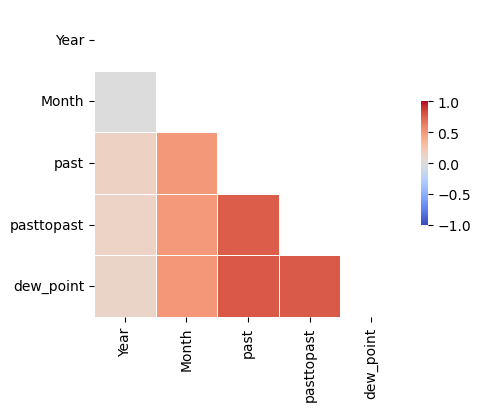

In [7]:
f, ax = plt.subplots(figsize=(5, 4)) 
heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,linewidths = .5, cmap = 'coolwarm', cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},vmin = -1, vmax = 1,annot = True,annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [8]:
dp=dp.drop(['Year','Month'],axis=1)

In [9]:
dp.shape

(360, 3)

In [10]:
X=dp.drop('dew_point',axis=1)
y=dp.dew_point

In [11]:
X

,past,pasttopast
0,19.021875,19.520000
1,16.450000,19.885625
2,18.985625,21.385000
3,20.976875,22.600625
4,22.047500,23.231250
...,...,...
355,21.808750,23.438750
356,22.465625,23.964375
357,23.291250,23.807500
358,22.704375,23.633750


In [12]:
y

0      18.471875
1      20.180000
2      21.426875
3      21.978750
4      22.771875
         ...    
355    22.521875
356    23.681250
357    23.954375
358    23.889375
359    22.460625
Name: dew_point, Length: 360, dtype: float64

In [13]:
X.shape

(360, 2)

In [14]:
y.shape

(360,)

In [15]:
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping data for LSTM/GRU/RNN (samples, timesteps, features)
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# GRU

In [16]:
def create_gru_model(units=64):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [17]:
gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_40040\2098133132.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)


In [18]:
# Define the hyperparameter grid
gru_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [19]:
gru_grid = GridSearchCV(estimator=gru_model, param_grid=gru_param_grid, cv=3, scoring='neg_mean_squared_error')

In [20]:
gru_grid_result = gru_grid.fit(X_train, y_train)

In [21]:
print(f"Best GRU params: {gru_grid_result.best_params_}")
print(f"Best GRU score: {gru_grid_result.best_score_}")

Best GRU params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best GRU score: -0.8178092568688723


# LSTM

In [22]:
def create_lstm_model(units=64):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [23]:
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_40040\1916978622.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [24]:
# Define the hyperparameter grid
lstm_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [25]:
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=lstm_param_grid, cv=3, scoring='neg_mean_squared_error')

In [26]:
lstm_grid_result = lstm_grid.fit(X_train, y_train)

In [27]:
print(f"Best LSTM params: {lstm_grid_result.best_params_}")
print(f"Best LSTM score: {lstm_grid_result.best_score_}")

Best LSTM params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best LSTM score: -0.820710871160324


# RNN

In [28]:
def create_rnn_model(units=64):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [29]:
rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_40040\361697586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)


In [30]:
rnn_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [31]:
rnn_grid = GridSearchCV(estimator=rnn_model, param_grid=rnn_param_grid, cv=3, scoring='neg_mean_squared_error')

In [32]:
rnn_grid_result = rnn_grid.fit(X_train, y_train)

In [33]:
print(f"Best SimpleRNN params: {rnn_grid_result.best_params_}")
print(f"Best SimpleRNN score: {rnn_grid_result.best_score_}")

Best SimpleRNN params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best SimpleRNN score: -0.9700794181265507


In [34]:
# Evaluating GRU model on test data
best_gru_model = gru_grid_result.best_estimator_
y_pred_gru = best_gru_model.predict(X_test)
mse_gru = mean_squared_error(y_test, y_pred_gru)


print(f"GRU Model - MSE: {mse_gru}")

# Evaluating LSTM model on test data
best_lstm_model = lstm_grid_result.best_estimator_
y_pred_lstm = best_lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)


print(f"LSTM Model - MSE: {mse_lstm}")

# Evaluating SimpleRNN model on test data
best_rnn_model = rnn_grid_result.best_estimator_
y_pred_rnn = best_rnn_model.predict(X_test)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)


print(f"SimpleRNN Model - MSE: {mse_rnn}")


GRU Model - MSE: 0.7280651362722854
LSTM Model - MSE: 0.7323647166343675
SimpleRNN Model - MSE: 0.7899256589461039


## LSTM is sutaible for Dew Point with least MSE

In [44]:
dewpoint2021=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\dew_point.csv")

In [45]:
dewpoint2021 = dewpoint2021.drop(['Year','Month'],axis=1)

In [46]:
dewpoint2021

,past,pasttopast
0,18.863750,19.485000
1,20.686875,19.757500
2,20.494375,20.844375
3,22.112500,22.955000
4,23.584375,23.988125
5,23.045000,22.678750
6,22.470625,22.463750
7,22.521875,21.808750
8,23.681250,22.465625
9,23.954375,23.291250


In [47]:
dewpoint2020_pred=[]

In [48]:
dewpoint2021_scaled = scaler.transform(dewpoint2021)

# Reshape for prediction
dewpoint2021_scaled = np.reshape(dewpoint2021_scaled, (dewpoint2021_scaled.shape[0], dewpoint2021_scaled.shape[1], 1))

In [49]:
best_model = gru_grid_result.best_estimator_

dewpoint2020_pred=best_model.predict(dewpoint2021_scaled)

In [50]:
dewpoint2020_pred

array([19.475208, 21.05653 , 21.020924, 22.267494, 23.08099 , 22.745169,
       22.43121 , 22.41179 , 23.033712, 23.202387, 23.140453, 22.365253],
      dtype=float32)

In [1]:
dewpoint_data=pd.DataFrame(data=dewpoint2020_pred)
dewpoint_data

,0
0,21.475208
1,21.056530
2,20.020924
3,22.267494
4,23.080990
5,22.745169
6,22.431210
7,23.411790
8,23.033712
9,23.202387


In [52]:
dewpoint_data.to_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\dew_point1.csv")